In [1]:
import pandas as pd
import stock_data as stock
from tqdm import tqdm

## Get top50

In [ ]:
start = "2010-01-01"
end = "2021-12-31"
mode = "all"

scrapy = stock.Scrapy()
df0 = scrapy.get_price(start, end, mode)

In [ ]:
df0["Date"] = df0["Date"].apply(lambda X: X.date())
df0["Year"] = df0["Date"].apply(lambda X: X.year)
g = df0.groupby(["Symbol", "Year"])
cat = g.size().keys()

data = []
for i in tqdm(range(len(cat))):
    sample = []
    df1 = g.get_group(cat[i])
    min_ = df1.loc[df1["Close"].idxmin()][["Date", "Close"]].values
    max_ = df1.loc[df1["Close"].idxmax()][["Date", "Close"]].values
    return_ = (df1["Close"].max() - df1["Close"].min()) / df1["Close"].min()

    sample.extend(list(cat[i]))
    sample.extend(min_)
    sample.extend(max_)
    sample.append(return_)
    data.append(sample)
df = pd.DataFrame(data, columns = ["symbol", "year", "min_date", "min_price", "max_date", "max_price", "return"])
df

In [ ]:
df["market"] = df["symbol"].apply(lambda X: X.split(".")[-1])
df["symbol"] = df["symbol"].str[:4]
df = df.query("min_price >= 5")
df = df.reset_index(drop = True)
df

In [ ]:
df = df.query("max_date > min_date")
df = df.reset_index(drop = True)
df

In [ ]:
g = df.groupby(["year", "market"])
cat = g.size().keys()

df2 = pd.DataFrame()
for i in tqdm(range(len(cat))):
    df1 = g.get_group(cat[i])
    df2 = pd.concat([df2, df1.nlargest(50, "return")], ignore_index = True)
df2 = df2.sort_values(["year", "market", "return"])
df2 = df2[['year', 'market', 'symbol', 'min_date', 'min_price', 'max_date', 'max_price', 'return']]
df2["return"] = df2["return"].round(4)
df2

In [ ]:
df2.to_csv("data/top50.csv", index = False)

## Get financial data

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 1,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/income102_111.csv", index = False)

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 2,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/balance102_111.csv", index = False)

## Merge

In [2]:
df1 = pd.read_csv("data/top50.csv")
df1 = df1.query("year >= 2014")
df1 = df1.reset_index(drop = True)
df1.head()

,year,market,symbol,min_date,min_price,max_date,max_price,return
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644


In [3]:
df2 = pd.read_csv("data/income102_111.csv")
df2 = df2.query("season == 4")
df2["year"] = df2["year"] + 1911
df2 = df2[["year", "公司代號", "每股盈餘(元)"]]
df2.columns = ["year", "symbol", "eps"]
df2 = df2.sort_values(["symbol", "year"])
df2 = df2.reset_index(drop = True)
df2.head()

,year,symbol,eps
0,2013,1101,2.72
1,2014,1101,2.93
2,2015,1101,1.56
3,2016,1101,1.72
4,2017,1101,2.03


In [4]:
df3 = pd.read_csv("data/balance102_111.csv")
df3 = df3.query("season == 4")
df3["year"] = df3["year"] + 1911
df3 = df3[["year", "公司代號", "股本"]]
df3.columns = ["year", "symbol", "capital"]
df3 = df3.sort_values(["symbol", "year"])
df3 = df3.reset_index(drop = True)
df3.head()

,year,symbol,capital
0,2013,1101,36921759.0
1,2014,1101,36921759.0
2,2015,1101,36921759.0
3,2016,1101,36921759.0
4,2017,1101,42465090.0


In [5]:
for i in range(1, df2["year"].nunique()):
    df2[f"last{i}_eps"] = df2.groupby("symbol")["eps"].shift(i)
df2

,year,symbol,eps,last1_eps,last2_eps,last3_eps,last4_eps,last5_eps,last6_eps,last7_eps,last8_eps
0,2013,1101,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1101,2.93,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1101,1.56,2.93,2.72,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1101,1.72,1.56,2.93,2.72,NaN,NaN,NaN,NaN,NaN
4,2017,1101,2.03,1.72,1.56,2.93,2.72,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15205,2017,9962,0.66,0.74,-0.73,0.20,0.77,NaN,NaN,NaN,NaN
15206,2018,9962,1.04,0.66,0.74,-0.73,0.20,0.77,NaN,NaN,NaN
15207,2019,9962,0.13,1.04,0.66,0.74,-0.73,0.20,0.77,NaN,NaN
15208,2020,9962,0.01,0.13,1.04,0.66,0.74,-0.73,0.20,0.77,NaN


In [6]:
df = pd.merge(df1, df2, left_on = ["year", "symbol"], right_on = ["year", "symbol"], how = "left")
df = df.reset_index(drop = True)
print(len(df))
df.head()

800


,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,last3_eps,last4_eps,last5_eps,last6_eps,last7_eps,last8_eps
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567,2.14,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644,3.98,4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df3["last_capital"] = df3.groupby("symbol")["capital"].shift()
df3 = df3.dropna()
df3

,year,symbol,capital,last_capital
1,2014,1101,36921759.0,36921759.0
2,2015,1101,36921759.0,36921759.0
3,2016,1101,36921759.0,36921759.0
4,2017,1101,42465090.0,36921759.0
5,2018,1101,53080599.0,42465090.0
...,...,...,...,...
15205,2017,9962,902203.0,902203.0
15206,2018,9962,902203.0,902203.0
15207,2019,9962,902203.0,902203.0
15208,2020,9962,902203.0,902203.0


In [8]:
df = pd.merge(df, df3, left_on = ["year", "symbol"], right_on = ["year", "symbol"], how = "left")
df = df.reset_index(drop = True)
print(len(df))
df.head()

800


,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,last3_eps,last4_eps,last5_eps,last6_eps,last7_eps,last8_eps,capital,last_capital
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246960.0,176400.0
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2261076.0,2261076.0
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,708435.0,616400.0
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567,2.14,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833855.0,833855.0
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644,3.98,4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,884880.0,705960.0


In [9]:
df = df.query("capital < last_capital")
df.shape

(78, 19)

In [10]:
df = df.query("(eps > last1_eps)")
df.shape

(66, 19)

## Analysis

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df["eps_diff"] = df["eps"] - df["last1_eps"]
df.head(3)

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,last3_eps,last4_eps,last5_eps,last6_eps,last7_eps,last8_eps,capital,last_capital,eps_diff
7,2014,TW,3605,2014-01-03,22.70,2014-08-28,47.90,1.1101,3.65,1.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1240759.0,1244009.0,2.09
18,2014,TW,3094,2014-01-02,21.20,2014-06-17,47.50,1.2406,1.00,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,832151.0,852891.0,0.13
27,2014,TW,2327,2014-01-02,33.44,2014-11-28,76.85,1.2981,2.30,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6678919.0,15437159.0,1.55


<AxesSubplot:xlabel='eps_diff', ylabel='return'>

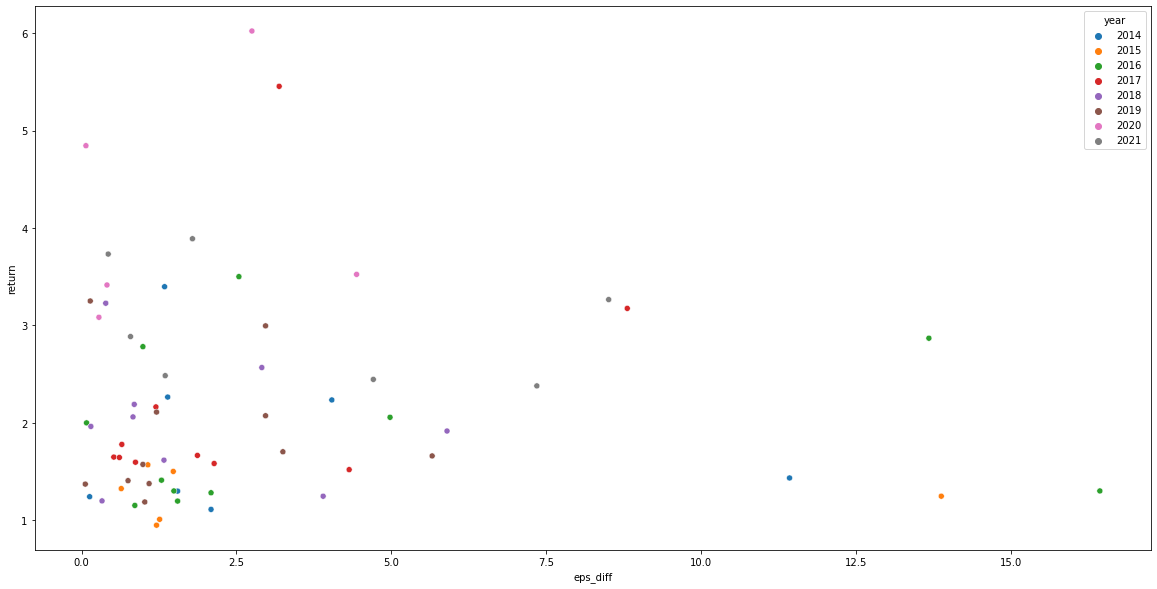

In [13]:
plt.figure(figsize = (20, 10))
sns.color_palette("tab10")
sns.scatterplot(x = "eps_diff", y = "return", data = df, hue = "year", palette = "tab10")

In [ ]:
df.to_excel("data/top50_1.xlsx", index = False)